In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2018, 2, 25)
end = dt.datetime(2022, 2,25)

data = yf.download(crypto_currency, start, end)

df = pd.read_csv ('kaggleSentiments.csv')
articles = df.loc[:,"articles"]
df1 = df.iloc[850:]
df1

[*********************100%%**********************]  1 of 1 completed


,Unnamed: 0.1,Unnamed: 0,begins_at,open_price,close_price,high_price,low_price,symbol,articles,sentiments
850,850,850,2020-06-25,234.290000,232.355000,235.955000,226.730000,ETH,['Ethereum 2.0: Is the Interest Real or Hype A...,2.600000
851,851,851,2020-06-26,231.910000,229.545000,234.050000,225.269961,ETH,['Bitcoin Mixer - An Extra layer of Privacy to...,2.500000
852,852,852,2020-06-27,229.270000,220.900000,232.037930,214.689844,ETH,['Bitcoin Price Analysis: Will The 2015 Histor...,2.333333
853,853,853,2020-06-28,220.435000,224.955000,228.460000,216.987754,ETH,['Weekly Recap: Bitcoin (BTC) Awaits Decisive ...,2.600000
854,854,854,2020-06-29,224.500000,227.935000,230.375000,220.603569,ETH,['ETH Price Stuck at Around $225 as Number of ...,3.400000
...,...,...,...,...,...,...,...,...,...,...
1821,1821,1821,2023-02-21,1703.534310,1660.190459,1716.578831,1635.991875,ETH,['Ethereum price rally hit crucial resistance ...,2.700000
1822,1822,1822,2023-02-22,1660.190459,1643.125062,1667.160000,1595.962806,ETH,"['Price analysis 2/22: BTC, ETH, BNB, XRP, ADA...",2.000000
1823,1823,1823,2023-02-23,1643.125062,1651.041004,1679.345471,1628.913450,ETH,['What the Ethereum Shanghai Upgrade Will Mean...,2.800000
1824,1824,1824,2023-02-24,1651.041004,1608.112881,1665.261642,1575.267503,ETH,"['Price analysis 2/24: BTC, ETH, BNB, XRP, ADA...",3.200000


In [2]:
from transformers import BertTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = TFAutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [3]:
def find_sentiment(text):

    encoded_input = tokenizer(text, return_tensors='tf')
    outputs = model(encoded_input)

    predictions = tf.nn.softmax(outputs.logits, axis=-1)
    predicted_rating = tf.argmax(predictions, axis=1) + 1  # ratings from 1 to 5

    score = predicted_rating.numpy()[0]
    return score

In [4]:
price_scaler = MinMaxScaler(feature_range=(0,1))
sentiment_scaler = MinMaxScaler(feature_range=(0,1))

scaled_price = price_scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_sentiment = sentiment_scaler.fit_transform(df['sentiments'].values.reshape(-1,1))


prediction_days = 60

x_train, y_train = [], []

for i in range(prediction_days, len(scaled_price)):
    x_train.append(np.column_stack((scaled_price[i-prediction_days:i, 0], scaled_sentiment[i-prediction_days:i, 0])))
    y_train.append(scaled_price[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

Epoch 1/25
44/44 [==============================] - 4s 44ms/step - loss: 0.0157
Epoch 2/25
44/44 [==============================] - 2s 45ms/step - loss: 0.0044
Epoch 3/25
44/44 [==============================] - 2s 46ms/step - loss: 0.0047
Epoch 4/25
44/44 [==============================] - 2s 45ms/step - loss: 0.0040
Epoch 5/25
44/44 [==============================] - 2s 48ms/step - loss: 0.0038
Epoch 6/25
44/44 [==============================] - 2s 46ms/step - loss: 0.0032
Epoch 7/25
44/44 [==============================] - 2s 45ms/step - loss: 0.0033
Epoch 8/25
44/44 [==============================] - 2s 46ms/step - loss: 0.0032
Epoch 9/25
44/44 [==============================] - 2s 47ms/step - loss: 0.0037
Epoch 10/25
44/44 [==============================] - 2s 46ms/step - loss: 0.0029
Epoch 11/25
44/44 [==============================] - 2s 44ms/step - loss: 0.0040
Epoch 12/25
44/44 [==============================] - 2s 45ms/step - loss: 0.0036
Epoch 13/25
44/44 [==================

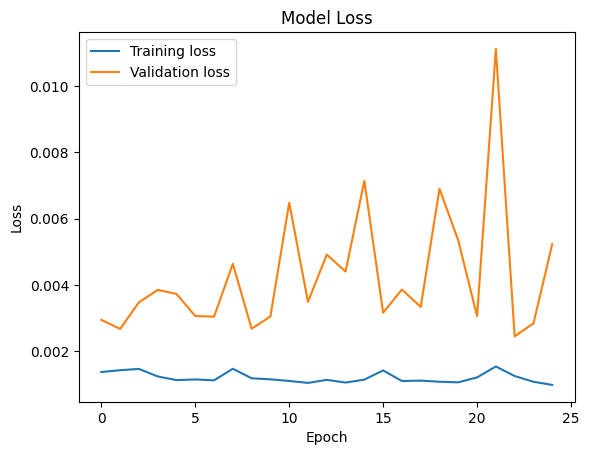

In [5]:

import keras
from keras import layers


model = keras.Sequential()
model.add(layers.LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(optimizer= 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)


history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)


plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

11/12 [==========================>...] - ETA: 0s

12/12 [==============================] - 0s 11ms/step


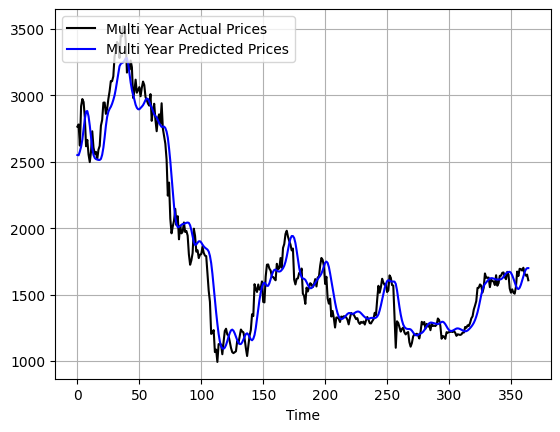

avg distance from actual price [98.43905]
Correct, Wrong and ratio if predicting price is up every day 177 187 0.48626373626373626
overall correct: 190 overall wrong: 174
longest overall correct streak: 8 longest overall wrong streak: 9
explained variance score: 0.9543356360348098
prediction window: 60


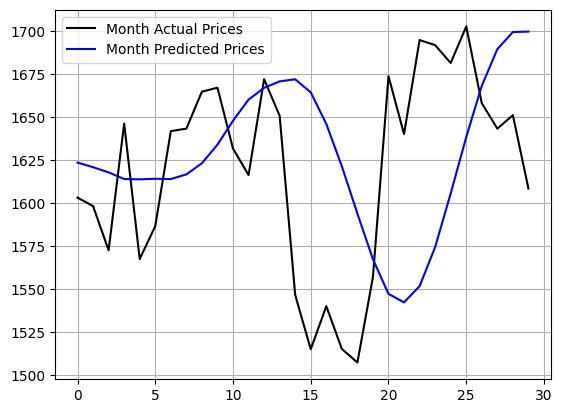

correct: 14 wrong: 15
longest correct streak: 4 longest wrong streak: 3



In [7]:

test_start = dt.datetime(2022, 2,25)
test_end = dt.datetime(2023, 2,25)

test_data = yf.download(crypto_currency, test_start, test_end)
sentiment_data = df.iloc[850:]


data_before_test = yf.download(crypto_currency, test_start - dt.timedelta(days=prediction_days), test_start)


actual_prices = test_data['Close'].values


total_price_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
total_sentiment_dataset = pd.concat((df['sentiments'], sentiment_data['sentiments']), axis=0)

model_inputs_price = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_sentiment = total_sentiment_dataset[len(total_sentiment_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)

model_inputs_price = price_scaler.transform(model_inputs_price)  
model_inputs_sentiment = sentiment_scaler.transform(model_inputs_sentiment)

#model_inputs_price = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
#model_inputs_volume = pd.concat((data['Volume'], test_data['Volume']), axis=0).values.reshape(-1,1)
#model_inputs_price = price_scaler.transform(model_inputs_price)  
#model_inputs_volume = volume_scaler.transform(model_inputs_volume) 

x_test = []


for i in range(prediction_days, len(model_inputs_price)):
    x_test.append(np.column_stack((model_inputs_price[i-prediction_days:i, 0], model_inputs_sentiment[i-prediction_days:i, 0])))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))


prediction_prices = model.predict(x_test)
prediction_prices = price_scaler.inverse_transform(prediction_prices[:, 0].reshape(-1, 1))


prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
baseline=0
base = []
for i in range(len(prediction_prices)):
    if i != 0:
        base.append(actual_prices[i - 1])
        avg += abs(prediction_prices[i] - actual_prices[i])
        if actual_prices[i] > actual_prices[i- 1]:
            baseline += abs(actual_prices[i-1]-actual_prices[i])
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
#print("baseline avg distance from actual price", baseline/len(prediction_prices))           
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)
print()